<a href="https://colab.research.google.com/github/asriva13/PINN/blob/main/Eikonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs
! apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! pip install dmsh
! pip install optimesh

In [ ]:
#@title Imports
%matplotlib inline
import jax.numpy as np
import numpy
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg
from jax.example_libraries import optimizers


# This import registers the 3D projection, but is otherwise unused.
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import LogNorm
import scipy as sc
from mpl_toolkits.axes_grid1 import ImageGrid
import string
import dmsh
import meshio
import optimesh
import meshplex
from numpy import loadtxt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.path as mpltPath
import scipy.io as sio

#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
#%matplotlib inline

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

key = random.PRNGKey(0)

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
#@title Functions
##################
#Definitions relevant to NN architecture.
########################
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

def ReLU2(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, np.sign(x)*x**2))

def ReLU3(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, x**3))

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def tanh(x):
    return 2.*sigmoid(2*x)-1.

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def relu2_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU2(np.dot(params[0], x) + params[1])

def relu3_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU3(np.dot(params[0], x) + params[1])

def sigmoid_layer(params, x):
    """ Simple ReLu layer for single sample """
    return sigmoid(np.dot(params[0], x) + params[1])

def tanh_layer(params, x):
    """ Simple ReLu layer for single sample """
    return tanh(np.dot(params[0], x) + params[1])

############################
############################


###########################
#####Data reshape

def datareshapeMLP(x,numBatches):
  #numpy.random.shuffle(x)
  if numBatches>1:
    l=len(x)
    numCol=int(l/numBatches)
    x=x[:l*numCol]
    x=x.reshape(numBatches,numCol)
  else:
    x=x.reshape(1,len(x))

  return x


############################
###Initialize weights for an MLP
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1.e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

############################

############################
############################

def error(params, x, y):
    ex = e_vect(x,y)
    e = u_vect(params,x,y) - e_vect(x,y)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

###########################
##########################
#Basic geometry; o=0 for cc and 1 for c
def polygon(points,o=0):
  l = len(points[:,0])
  segments = numpy.zeros((l,4))
  for i in range(l-1):
    segments[i,:2]=points[i,:]
    segments[i,2:4]=points[i+1,:]
  i = i+1
  segments[i,:2]=points[i,:]
  segments[i,2:4]=points[0,:]  

  if o==0:
    return segments
  else:
    return numpy.flip(segments,axis=0)



def NN(params, x, y):
    """ Compute the forward pass for each example individually """
    activations = np.array([x,y])

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu3_layer([w, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) + final_b

    return (final[0])


#################R functions and MVC

def dist(x1,y1,x2,y2):
  return np.sqrt((x2-x1)**2+(y2-y1)**2)

def linseg(x,y,x1,y1,x2,y2):
  L=dist(x1,y1,x2,y2)
  xc = (x1+x2)/2.
  yc = (y1+y2)/2.
  f = (1/L)*((x-x1)*(y2-y1) - (y-y1)*(x2-x1))
  t = (1/L)*((L/2.)**2-dist(x,y,xc,yc)**2)
  phi = np.sqrt(t**2+f**4)

  return np.sqrt(f**2 + (1/4.)*(phi - t)**2)

def R_eq(rho1,rho2,m):
  return rho1*rho2/((rho1**m + rho2**m)**(1/m))

def phi(x,y,segments):
  m = 1.
  # R = 1.
  R = 0.
  for i in range(len(segments[:,0])):
    rho = linseg(x,y,segments[i,0],segments[i,1],segments[i,2],segments[i,3])
    # R = R_eq(R,rho,m)
    R = R + 1./rho**m
  R = 1/R**(1/m)

  return R

def tanaby2(r1,r2):
  return np.linalg.norm(np.cross(r1,r2))/(np.linalg.norm(r1)*np.linalg.norm(r2) + np.dot(r1,r2))

def meanValue(x,y,segments):

  p = 1.

  W = 0.
  i = len(segments[:,0])-1
  a1,b1 = segments[i,0]-x,segments[i,1]-y
  a2,b2 = segments[0,0]-x,segments[0,1]-y
  a3,b3 = segments[0,2]-x,segments[0,3]-y
  tm1 = abs(a1*b2-a2*b1)/(dist(a1,b1,0.,0.)*dist(a2,b2,0.,0.) + a1*a2 + b1*b2)
  t = abs(a2*b3-a3*b2)/(dist(a2,b2,0.,0.)*dist(a3,b3,0.,0.) + a2*a3 + b2*b3)
  w = (t + tm1)/dist(a2,b2,0.,0.)
  W = W + w**p

  for j in range(len(segments[:,0])-1):
    i=j+1
    a1,b1 = segments[j,0]-x,segments[j,1]-y
    a2,b2 = segments[i,0]-x,segments[i,1]-y
    a3,b3 = segments[i,2]-x,segments[i,3]-y
    tm1 = abs(a1*b2-a2*b1)/(dist(a1,b1,0.,0.)*dist(a2,b2,0.,0.) + a1*a2 + b1*b2)
    t = abs(a2*b3-a3*b2)/(dist(a2,b2,0.,0.)*dist(a3,b3,0.,0.) + a2*a3 + b2*b3)
    w = (t + tm1)/dist(a2,b2,0.,0.)
    W = W + w**p

  return 1./W**(1/p)

def g(x,y,segments):
  mu = 1.
  R = 0.
  for i in range(len(segments[:,0])):
    rho = linseg(x,y,segments[i,0],segments[i,1],segments[i,2],segments[i,3])
    R = R + rho**(-mu)

  w3 = (linseg(x,y,segments[2,0],segments[2,1],segments[2,2],segments[2,3]))**(-mu)/R
  g = np.sin(np.pi*x)*w3

  return g


gxx = grad(grad(g,0),0) 
gyy = grad(grad(g,1),1)
phixx = grad(grad(phi,0),0) 
phix = grad(phi,0) 
phiyy = grad(grad(phi,1),1)
meanValuexx = grad(grad(meanValue,0),0)
meanValueyy = grad(grad(meanValue,1),1)

g_vect = vmap(g, (0, 0, None))
gxx_vect = vmap(gxx, (0, 0, None))
gyy_vect = vmap(gyy, (0, 0, None))
R_vect = vmap(phi, (0, 0, None))
phix_vect = vmap(phix, (0, 0, None))
phixx_vect = vmap(phixx, (0, 0, None))
phiyy_vect = vmap(phiyy, (0, 0, None))
meanValue_vect = vmap(meanValue, (0, 0, None))
meanValuexx_vect = vmap(meanValuexx, (0, 0, None))
meanValueyy_vect = vmap(meanValueyy, (0, 0, None))
#####################

def gridValues(x,y,z):
  l = int(numpy.sqrt(len(x)))
  grid_x, grid_y = numpy.mgrid[min(x):max(x):l*1j, min(y):max(y):l*1j]
  values = z.reshape((l,l))
  return grid_x.T,grid_y.T,values


In [ ]:
#@title Checking codes for mesh generation using meshgrid

numBatches=1
#Outer square
inputx = numpy.linspace(-1., 1., num=70)
inputy = numpy.linspace(-1., 1., num=70)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#Interior square
p2 = .5*numpy.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
segments2 = polygon(p2,0)
geo2 = dmsh.Polygon(p2)
X2, cells2 = dmsh.generate(geo2, 0.05)
# optionally optimize the mesh
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)
path = mpltPath.Path(p2)

# dmsh.helpers.show(X2, cells2, geo2)
# geo2.show()

#Boundary points
Xb2 = X2[mesh2.is_boundary_point]
Xb = Xb2
xb, yb = Xb[:,0], Xb[:,1]


# # #For plotting
x = numpy.linspace(-1., 1., num=100)
y = numpy.linspace(-1., 1., num=100)
x, y = numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
xy = numpy.zeros((len(x),2))
xy[:,0]=x
xy[:,1]=y


path = mpltPath.Path(p2)
inside = path.contains_points(xy)
print(inside)
x = inside*1
x[x==0]=-1
print(x)

[-1 -1 -1 ... -1 -1 -1]


epoch:   0 loss: 0.973512
epoch: 1000 loss: 0.060937
epoch: 2000 loss: 0.020557
epoch: 3000 loss: 0.019888
epoch: 4000 loss: 0.018901
epoch: 5000 loss: 0.016274
epoch: 6000 loss: 0.014639
epoch: 7000 loss: 0.012712
epoch: 8000 loss: 0.011254
epoch: 9000 loss: 0.010334
epoch: 10000 loss: 0.009599
epoch: 11000 loss: 0.009086
epoch: 12000 loss: 0.008778
epoch: 13000 loss: 0.008484
epoch: 14000 loss: 0.008235
epoch: 15000 loss: 0.008059
epoch: 16000 loss: 0.008220
epoch: 17000 loss: 0.007701
epoch: 18000 loss: 0.007569
epoch: 19000 loss: 0.007451
epoch: 20000 loss: 0.007347
epoch: 21000 loss: 0.007283
epoch: 22000 loss: 0.007174
epoch: 23000 loss: 0.007089
epoch: 24000 loss: 0.007017
epoch: 25000 loss: 0.006937
epoch: 26000 loss: 0.006901
epoch: 27000 loss: 0.007631
epoch: 28000 loss: 0.006695
epoch: 29000 loss: 0.006612
epoch: 30000 loss: 0.006531
epoch: 31000 loss: 0.006452
epoch: 32000 loss: 0.006369
epoch: 33000 loss: 0.006334
epoch: 34000 loss: 0.006196
epoch: 35000 loss: 0.006109
epo

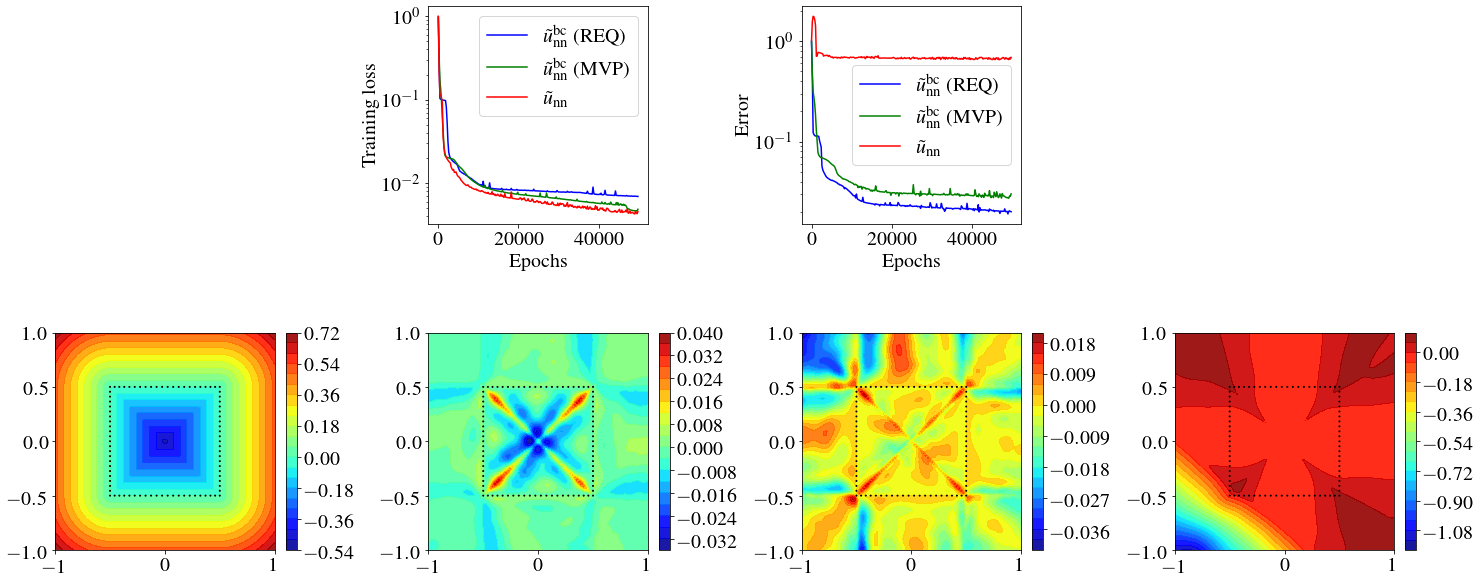

In [ ]:
#@title Eikonal, square inside a square

numBatches = 1
num_epochs = 50000

def f(x,y):
  return 1.

f_vect = vmap(f, (0, 0))

#Outer square
inputx = numpy.linspace(-1., 1., num=100)
inputy = numpy.linspace(-1., 1., num=100)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#Interior square
p2 = .5*numpy.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
segments2 = polygon(p2,0)
geo2 = dmsh.Polygon(p2)
X2, cells2 = dmsh.generate(geo2, 0.05)
# optionally optimize the mesh
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)

# dmsh.helpers.show(X2, cells2, geo2)
# geo2.show()

#Boundary points
Xb2 = X2[mesh2.is_boundary_point]
Xb = Xb2
xb, yb = Xb[:,0], Xb[:,1]


# # #For plotting
xi = numpy.linspace(-1., 1., num=100)
yi = numpy.linspace(-1., 1., num=100)
xi, yi = numpy.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()
xy = numpy.zeros((len(xi),2))
xy[:,0]=xi
xy[:,1]=yi
path = mpltPath.Path(p2)
inside = path.contains_points(xy)
inside = inside*1
inside[inside==0]=-1
inside=inside*-1


#NN
layer_sizes = [2, 30, 30, 30, 1]

def exact(x,y):
  R=np.array([.5,.5])
  p=np.array([x,y])
  z=np.array([0.,0.])
  q = np.abs(p)-R
  d = np.linalg.norm(np.maximum(q,z)) + np.amin(np.array([np.amax(q),0.]))
  return d

e_vect = vmap(exact, (0, 0))



###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def errorM(params, x, y):
    ex = e_vect(x,y)
    e = inside*u_vect(params,x,y) - e_vect(x,y)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))


def uM(params, x, y):
    return meanValue(x,y,segments2)*NN(params,x,y)

def lossM(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uM,1)
grad2 = grad(uM,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorM(params, xi, yi)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, xi, yi))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.
# errorxyM1 = numpy.abs(exactSoln1 - approxSolnM1)/numpy.sqrt(numpy.mean(exactSoln1**2))

##########################################################




###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def errorR(params, x, y):
    ex = e_vect(x,y)
    e = inside*u_vect(params,x,y) - e_vect(x,y)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def uR(params, x, y):
    # return -1.*np.sign(exact(x,y))*phi(x,y,segments2)*NN(params,x,y)
    return phi(x,y,segments2)*NN(params,x,y)

def lossR(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorR(params, xi, yi)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, xi, yi))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

exactSoln1 = numpy.array(e_vect(xi,yi))

# errorxyR1 = numpy.abs(exactSoln1 - approxSolnR1)/numpy.sqrt(numpy.mean(exactSoln1**2))
##########################################################



###################################
#No Dirichlet

layer_sizes = [2, 70, 70, 1]

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uNBC(params, x, y):
    return NN(params,x,y)

def lossNBC(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    bc = u_vect(params,xb,yb)
    return np.mean(eq**2) + np.mean(bc**2)

grad1 = grad(uNBC,1)
grad2 = grad(uNBC,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uNBC, (None, 0, 0))


def run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateNBC(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateNBC(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er
    
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingNBC(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorNBC1 = e
lossNBC1 = train_loss
approxSolnNBC1 = numpy.array(u_vect(params, xi, yi))
approxSolnNBC1[numpy.isnan(approxSolnNBC1)] = 0.
# errorxyNBC1 = numpy.abs(exactSoln1 - approxSolnNBC1)/numpy.sqrt(numpy.mean(exactSoln**2))
####################################

e_dx = 200

s = [1. for n in range(len(xb))]

plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(24, 10))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=.7)
gs.update(hspace=.5)
ax1 = plt.subplot(gs[0, 1], )
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[1, 3])

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (REQ)')
ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="green", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
ax1.plot(range(num_epochs)[::e_dx],lossNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (REQ)')
ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="green", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
ax2.plot(range(num_epochs)[::e_dx],errorNBC1[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
# ax2.text(-.1, 1., 'b', size=20, transform=ax2.transAxes)


X,Y,Z = gridValues(xi,yi,exactSoln1)

im3 = ax3.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# ax3.set_title('Exact solution')
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')
# ax3.text(-.1, 1.05, 'c', size=20, transform=ax3.transAxes)
# cbar = fig.colorbar(cs)
ax3.scatter(xb,yb,s, color="black")
axins = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im3, cax=axins)


X,Y,Z = gridValues(xi,yi,inside*approxSolnR1-exactSoln1)

im4 = ax4.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# ax4.set_title('$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (R-eq)')
# ax4.set_xlabel('$x$')
# ax4.set_ylabel('$y$')
ax4.scatter(xb,yb,s, color="black")
axins = inset_axes(ax4,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax4.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im4, cax=axins)

X,Y,Z = gridValues(xi,yi,inside*approxSolnM1-exactSoln1)

im5 = ax5.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# ax5.set_title('$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
# ax5.set_xlabel('$x$')
# ax5.set_ylabel('$y$')
ax5.scatter(xb,yb,s, color="black")
axins = inset_axes(ax5,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax5.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im5, cax=axins)


X,Y,Z = gridValues(xi,yi,approxSolnNBC1-exactSoln1)

im6 = ax6.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# ax6.set_title('$\\tilde{u}_\mathrm{nn}$')
# ax6.set_xlabel('$x$')
# ax6.set_ylabel('$y$')
ax6.scatter(xb,yb,s, color="black")
# ax6.text(-.1, 1.05, 'f', size=20, transform=ax6.transAxes)
axins = inset_axes(ax6,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax6.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im6, cax=axins)

fig.savefig('Eikonal-square.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = .2)

plt.show()

epoch:   0 loss: 0.448378
epoch: 1000 loss: 0.295253
epoch: 2000 loss: 0.295107
epoch: 3000 loss: 0.250747
epoch: 4000 loss: 0.119991
epoch: 5000 loss: 0.086493
epoch: 6000 loss: 0.063742
epoch: 7000 loss: 0.044606
epoch: 8000 loss: 0.032432
epoch: 9000 loss: 0.025429
epoch: 10000 loss: 0.021420
epoch: 11000 loss: 0.018458
epoch: 12000 loss: 0.016038
epoch: 13000 loss: 0.014009
epoch: 14000 loss: 0.012261
epoch: 15000 loss: 0.010430
epoch: 16000 loss: 0.008742
epoch: 17000 loss: 0.007806
epoch: 18000 loss: 0.006496
epoch: 19000 loss: 0.005600
epoch: 20000 loss: 0.005295
epoch: 21000 loss: 0.004746
epoch: 22000 loss: 0.004209
epoch: 23000 loss: 0.003906
epoch: 24000 loss: 0.003703
epoch: 25000 loss: 0.003619
epoch: 26000 loss: 0.003526
epoch: 27000 loss: 0.003426
epoch: 28000 loss: 0.003282
epoch: 29000 loss: 0.003249
epoch: 30000 loss: 0.003168
epoch: 31000 loss: 0.003218
epoch: 32000 loss: 0.002919
epoch: 33000 loss: 0.002746
epoch: 34000 loss: 0.002591
epoch: 35000 loss: 0.002430
epo

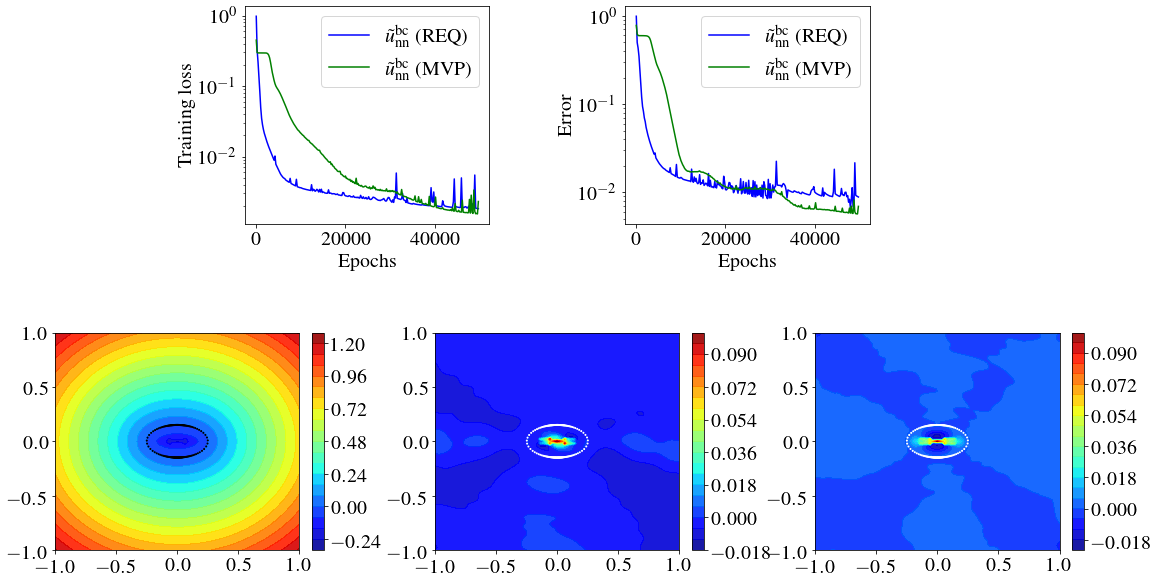

In [ ]:
#@title Ellipse

sa, sb = 0.25, 0.15

numBatches = 1
num_epochs = 50000

def f(x,y):
  return 1.

f_vect = vmap(f, (0, 0))

#Outer square
inputx = numpy.linspace(-1., 1., num=101)
inputy = numpy.linspace(-1., 1., num=101)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#Interior ellipse
geo2 = dmsh.Ellipse([0.0, 0.0], sa, sb)
X2, cells2 = dmsh.generate(geo2, 0.02)
# optionally optimize the mesh
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)

# dmsh.helpers.show(X2, cells2, geo2)
# geo2.show()

#Boundary points
Xb2 = X2[mesh2.is_boundary_point]
Xb = Xb2
xb, yb = Xb[:,0], Xb[:,1]


mat_contents = sio.loadmat('ellipse_exactdistance.mat')
p = mat_contents['points_d']
XX,YY,e_vect_v = p[:,0],p[:,1],p[:,2]
e_vect_v = e_vect_v.reshape((101,101))
e_vect_v = e_vect_v.T
e_vect_v = e_vect_v.flatten()

# # #For plotting
xi = numpy.linspace(-1., 1., num=101)
yi = numpy.linspace(-1., 1., num=101)
xi, yi = numpy.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()
inside = numpy.zeros_like(xi)
for i in range(len(xi)):
  t = xi[i]**2/sa**2 + yi[i]**2/sb**2 -1
  if t<0:
    inside[i]=-1
  else:
    inside[i]=1


#NN
# layer_sizes = [2, 50, 50, 1]
layer_sizes = [2, 30, 30, 30, 1]

# rx=sa
# ry=sb

# def ellipe_tan_dot(px, py, theta):
#     '''Dot product of the equation of the line formed by the point
#     with another point on the ellipse's boundary and the tangent of the ellipse
#     at that point on the boundary.
#     '''
#     return ((rx ** 2 - ry ** 2) * np.cos(theta) * np.sin(theta) -
#             px * rx * np.sin(theta) + py * ry * np.cos(theta))


# def ellipe_tan_dot_derivative(px, py, theta):
#     '''The derivative of ellipe_tan_dot.
#     '''
#     return ((rx ** 2 - ry ** 2) * (np.cos(theta) ** 2 - np.sin(theta) ** 2) -
#             px * rx * np.cos(theta) - py * ry * np.sin(theta))


# def estimate_distance(x, y):
#     '''Given a point (x, y), and an ellipse with major - minor axis (rx, ry),
#     its center at (x0, y0), and with a counter clockwise rotation of
#     `angle` degrees, will return the distance between the ellipse and the
#     closest point on the ellipses boundary.
#     '''
#     x0,y0,angle = 0.,0.,0.
#     error = 1e-5
#     x -= x0
#     y -= y0
#     if angle:
#         # rotate the points onto an ellipse whose rx, and ry lay on the x, y
#         # axis
#         angle = -np.pi / 180. * angle
#         x, y = x * np.cos(angle) - y * np.sin(angle), x * np.sin(angle) + y * np.cos(angle)

#     theta = np.arctan2(rx * y, ry * x)
#     for i in range(100):
#         theta -= ellipe_tan_dot(x, y, theta) / \
#             ellipe_tan_dot_derivative(x, y, theta)

#     px, py = rx * np.cos(theta), ry * np.sin(theta)
#     return ((x - px) ** 2 + (y - py) ** 2) ** .5


# e_vect = vmap(estimate_distance, (0, 0))
# e_vect_v = e_vect(xi,yi)
ex = e_vect_v



###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def errorM(params, x, y):
    e = -u_vect(params,x,y) - ex
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def phiM(x,y):
    p=1

    temp = x**2/sa**2 + y**2/sb**2 -1
    temp = np.where(temp==0,0,1)
    
    t = np.linspace(0.,1.,2000)
    a1,b1,a2,b2 = sa*np.cos(2*np.pi*t)-x,sb*np.sin(2*np.pi*t)-y,-2*sa*np.pi*np.sin(2*np.pi*t),2*sb*np.pi*np.cos(2*np.pi*t)
    num = a1*b2-b1*a2
    den = np.sqrt(a1**2 + b1**2)
    W=num/den**(2+p)
    Wp=np.trapz(W,t)
    return temp*1./Wp**(1/p)

def uM(params, x, y):
    return phiM(x,y)*NN(params,x,y)

def lossM(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uM,1)
grad2 = grad(uM,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorM(params, xi, yi)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, xi, yi))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.

##########################################################




###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def omega(x,y):
  return 1.-x**2/sa**2-y**2/sb**2

gwx = grad(omega,0)
gwy = grad(omega,1)  

def phiR(x,y):
    w=omega(x,y)
    wx = gwx(x,y)
    wy = gwy(x,y)
    return w/np.sqrt(w**2 + wx**2 + wy**2)

def errorR(params, x, y):
    e = -u_vect(params,x,y) - ex
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def uR(params, x, y):
    return phiR(x,y)*NN(params,x,y)

def lossR(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorR(params, xi, yi)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, xi, yi))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

# exactSoln1 = numpy.array(e_vect(xi,yi))


e_dx = 200

s = [1. for n in range(len(xb))]


plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=2.5)
gs.update(hspace=.5)
ax1 = plt.subplot(gs[0, 1:3])
ax2 = plt.subplot(gs[0, 3:5])
ax3 = plt.subplot(gs[1, 0:2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[1, 4:6])


ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (REQ)')
ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="green", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (REQ)')
ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="green", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')


X,Y,Z = gridValues(xi,yi,ex)
# Z=Z.T
im3 = ax3.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
ax3.scatter(xb,yb,s, color="black")
axins = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im3, cax=axins)


X,Y,Z = gridValues(xi,yi,-approxSolnR1-ex)
im4 = ax4.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
ax4.scatter(xb,yb,s, color="white")
axins = inset_axes(ax4,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax4.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im4, cax=axins)


X,Y,Z = gridValues(xi,yi,-approxSolnM1-ex)
im5 = ax5.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
ax5.scatter(xb,yb,s, color="white")
axins = inset_axes(ax5,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax5.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im5, cax=axins)


fig.savefig('Eikonal-ellipse.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = .2)

plt.show()

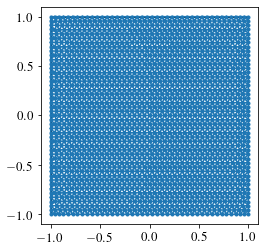

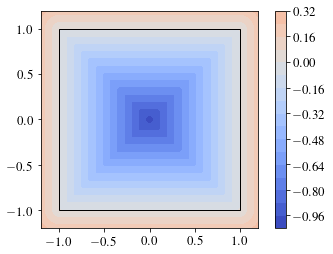

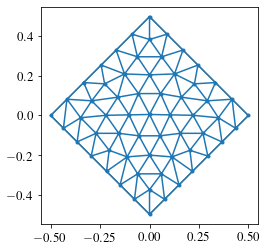

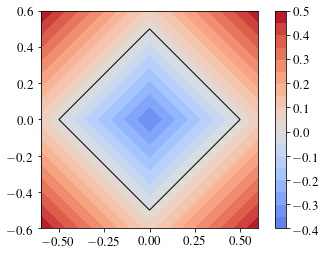

epoch:   0 loss: 0.994600
epoch: 1000 loss: 0.124206
epoch: 2000 loss: 0.105528
epoch: 3000 loss: 0.093292
epoch: 4000 loss: 0.086432
epoch: 5000 loss: 0.086127
epoch: 6000 loss: 0.078691
epoch: 7000 loss: 0.076432
epoch: 8000 loss: 0.074518
epoch: 9000 loss: 0.072993
epoch: 10000 loss: 0.071789
epoch: 11000 loss: 0.070728
epoch: 12000 loss: 0.069827
epoch: 13000 loss: 0.068887
epoch: 14000 loss: 0.068419
epoch: 15000 loss: 0.067740
epoch: 16000 loss: 0.066688
epoch: 17000 loss: 0.066094
epoch: 18000 loss: 0.065250
epoch: 19000 loss: 0.064762
epoch: 20000 loss: 0.063814
epoch: 21000 loss: 0.063488
epoch: 22000 loss: 0.062300
epoch: 23000 loss: 0.061574
epoch: 24000 loss: 0.059897
epoch: 25000 loss: 0.059747
epoch: 26000 loss: 0.056463
epoch: 27000 loss: 0.054771
epoch: 28000 loss: 0.058215
epoch: 29000 loss: 0.053051
epoch: 30000 loss: 0.052539
epoch: 31000 loss: 0.052010
epoch: 32000 loss: 0.051597
epoch: 33000 loss: 0.051227
epoch: 34000 loss: 0.051140
epoch: 35000 loss: 0.050674
epo

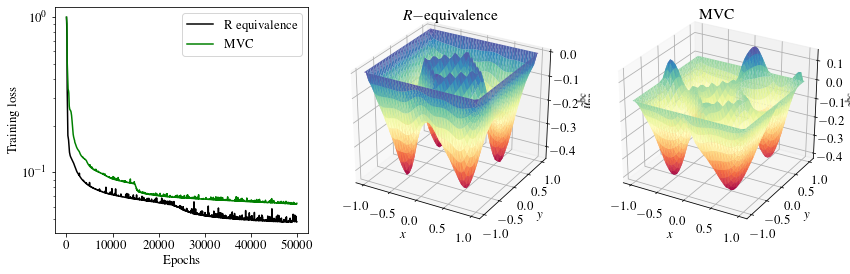

In [ ]:
#@title Eikonal - a square (at an angle) inside a square

numBatches = 1
num_epochs = 50000

def f(x,y):
  return 1.

f_vect = vmap(f, (0, 0))

#Outer square
p1 = numpy.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
segments1 = polygon(p1,0)
geo1 = dmsh.Polygon(p1)
X1, cells1 = dmsh.generate(geo1, 0.05)
# optionally optimize the mesh
X1, cells1 = optimesh.optimize_points_cells(X1, cells1, "CVT (full)", 1.0e-10, 100)
mesh1 = meshplex.MeshTri(X1, cells1)

dmsh.helpers.show(X1, cells1, geo1)
geo1.show()

#interior
inputx = mesh1.cell_centroids[:,0]
inputy = mesh1.cell_centroids[:,1]
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#Interior square
p2 = numpy.array([[0,-.5],[.5,0],[0,.5],[-.5,0.]])
segments2 = polygon(p2,1)
geo2 = dmsh.Polygon(p2)
X2, cells2 = dmsh.generate(geo2, 0.1)
# optionally optimize the mesh
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)

dmsh.helpers.show(X2, cells2, geo2)
geo2.show()

#Boundary points
Xb1 = X1[mesh1.is_boundary_point]
Xb2 = X2[mesh2.is_boundary_point]
Xb = numpy.append(Xb1,Xb2,axis=0)
xb, yb = Xb[:,0], Xb[:,1]



# #For plotting
x = mesh1.points[:,0]
y = mesh1.points[:,1]

#NN
layer_sizes = [2, 50, 50, 1]

def exact(x,y):
  return 0.

e_vect = vmap(exact, (0, 0))



###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    p1 = phi(x,y,segments1)
    p2 = phi(x,y,segments2)
    p = R_eq(p1,p2,2)
    return p*NN(params,x,y)

def lossR(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

# errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, x, y))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

# exactSoln1 = numpy.array(e_vect(x,y))

# errorxyR1 = numpy.abs(exactSoln1 - approxSolnR1)/numpy.sqrt(numpy.mean(exactSoln1**2))
##########################################################


###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    m1 = meanValue(x,y,segments1)
    m2 = meanValue(x,y,segments2)
    m = 1./(1./m1 + 1./m2)
    return m*NN(params,x,y)

def lossM(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uM,1)
grad2 = grad(uM,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

# errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, x, y))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.
# errorxyM1 = numpy.abs(exactSoln1 - approxSolnM1)/numpy.sqrt(numpy.mean(exactSoln1**2))

##########################################################


plt.rcParams.update({'font.size': 13})
######
#Plots
fig = plt.figure(figsize=(12, 4))
#fig.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})

# Adds subplot on position 1
ax1 = fig.add_subplot(131)
# Adds subplot on position 2
ax2 = fig.add_subplot(132, projection='3d')
# # Adds subplot on position 3
# ax3 = fig.add_subplot(143, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# # Adds subplot on position 2
# ax4 = fig.add_subplot(144)

e_dx = 50

ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='R equivalence')
ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="green", label='MVC')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot_trisurf(x, y, approxSolnR1, linewidth=0.2, antialiased=True, cmap=plt.cm.Spectral)
ax2.set_title('$R-$equivalence')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_zlabel('$\\tilde{u}_{\mathrm{nn}}^\mathrm{bc}$')
# ax2.text(0., 1., .7, 'c', size=20, transform=ax2.transAxes)


ax3.plot_trisurf(x, y, approxSolnM1, linewidth=0.2, antialiased=True, cmap=plt.cm.Spectral)
ax3.set_title('MVC')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_zlabel('$\\tilde{u}_{\mathrm{nn}}^\mathrm{bc}$')
# ax3.text(0., 1., .7, 'c', size=20, transform=ax3.transAxes)

plt.tight_layout()
fig.savefig('HeatEq.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


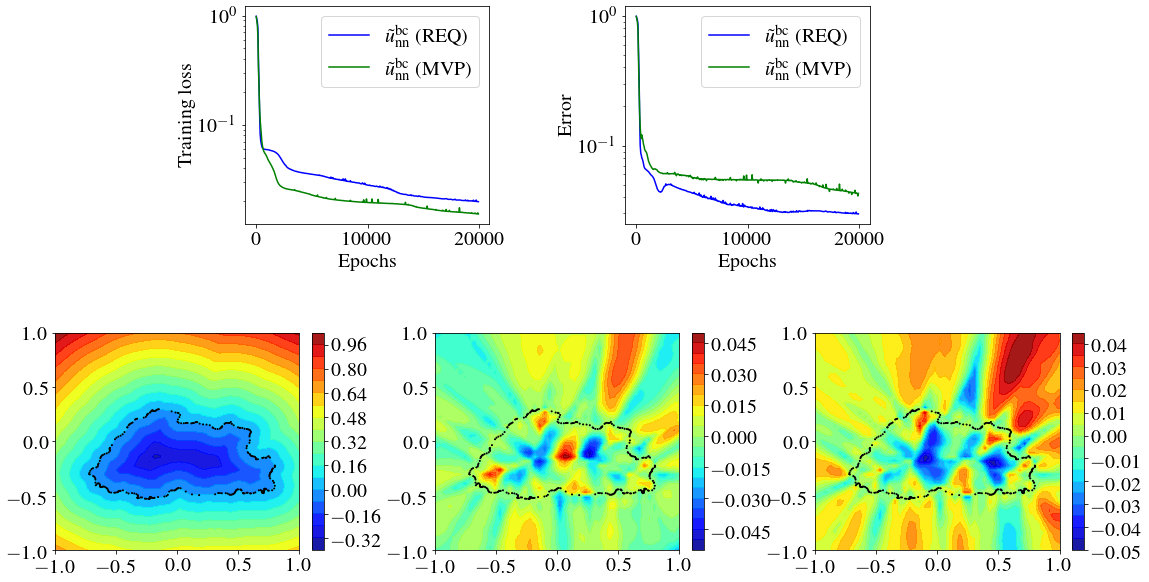

In [ ]:
#@title Eikonal on Bhutan

lines = loadtxt("bhutan_vertices.txt", comments="#", delimiter="  ", unpack=False)
p2 = numpy.asarray(lines)/250. - 2*np.array([.7,.6])


numBatches = 1
num_epochs = 20000

def f(x,y):
  return 1.

f_vect = vmap(f, (0, 0))

#Outer square
inputx = numpy.linspace(-1., 1., num=100)
inputy = numpy.linspace(-1., 1., num=100)
inputx, inputy = np.meshgrid(inputx, inputy)
inputx, inputy = inputx.flatten(), inputy.flatten()
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)

#Interior
segments2 = polygon(p2,0)
geo2 = dmsh.Polygon(p2)
X2, cells2 = dmsh.generate(geo2, 0.1)
# optionally optimize the mesh
X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
mesh2 = meshplex.MeshTri(X2, cells2)

dmsh.helpers.show(X2, cells2, geo2)
geo2.show()

#Boundary points
Xb2 = X2[mesh2.is_boundary_point]
Xb = Xb2
xb, yb = Xb[:,0], Xb[:,1]
s = [1. for n in range(len(xb))]

def exact(x,y):
  d = numpy.zeros(len(segments2[:,0]))
  for i in range(len(segments2[:,0])):
    x1,y1,x2,y2 = segments2[i,0], segments2[i,1], segments2[i,2], segments2[i,3]
    dd1 = dist(x,y,x1,y1)
    dd2 = dist(x,y,x2,y2)
    dd3 = numpy.abs((x2-x1)*(y1-y) - (y2-y1)*(x1-x))/dist(x1,y1,x2,y2)
    s1 = numpy.sqrt(dd3**2+dd1**2)
    s2 = numpy.sqrt(dd3**2+dd2**2)
    if (numpy.abs(s1+s2-dist(x1,y1,x2,y2))<1E-5):
      d[i]=dd3
    else:
      d[i] = numpy.amin(numpy.array([dd1,dd2]))

  dmin = numpy.amin(d)
  return dmin

# # #For plotting
xi = numpy.linspace(-1., 1., num=50)
yi = numpy.linspace(-1., 1., num=50)
xi, yi = numpy.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()
xy = numpy.zeros((len(xi),2))
xy[:,0]=xi
xy[:,1]=yi
path = mpltPath.Path(p2)
inside = path.contains_points(xy)
inside = inside*1
inside[inside==0]=-1
inside=inside*-1

# e_vect_v = numpy.zeros_like(xi)
# for i in range(len(xi)):
#   print(i)
#   e_vect_v[i] = exact(xi[i],yi[i])

# sio.savemat('MinDist.mat',{'e_vect_v':e_vect_v})

mat_contents = sio.loadmat('MinDist.mat')
e_vect_v = mat_contents['e_vect_v']

# e_vect = vmap(exact, (0, 0))
# e_vect_v = e_vect(xi,yi)
ex = inside*e_vect_v

#NN
# layer_sizes = [2, 50, 50, 1]
layer_sizes = [2, 30, 30, 30, 1]

# def exact(x,y):
#   return 0.

# e_vect = vmap(exact, (0, 0))



###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x, y):
    return phi(x,y,segments2)*NN(params,x,y)

def errorR(params, x, y):
    e = inside*u_vect(params,xi,yi) - ex
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))


def lossR(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uR,1)
grad2 = grad(uR,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uR, (None, 0, 0))


def run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateR(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorR(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorR1 = e
lossR1 = train_loss
approxSolnR1 = numpy.array(u_vect(params, xi, yi))
approxSolnR1[numpy.isnan(approxSolnR1)] = 0.

# exactSoln1 = numpy.array(e_vect(x,y))

# errorxyR1 = numpy.abs(exactSoln1 - approxSolnR1)/numpy.sqrt(numpy.mean(exactSoln1**2))
##########################################################


###################################
#Dirichlet Mean value

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uM(params, x, y):
    return meanValue(x,y,segments2)*NN(params,x,y)

def errorM(params, x, y):
    e = inside*u_vect(params,xi,yi) - ex
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))


def lossM(params, x, y):
    eq = np.sqrt(dudx_vect(params, x, y)**2 + dudy_vect(params, x, y)**2) - 1./f_vect(x,y)
    return np.mean(eq**2)

grad1 = grad(uM,1)
grad2 = grad(uM,2)
dudx_vect = vmap(grad1, (None, 0, 0))
dudy_vect = vmap(grad2, (None, 0, 0))
u_vect = vmap(uM, (None, 0, 0))

def run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputx[batch,:]
        y=inputy[batch,:]
        params, opt_state, loss, Er = updateM(params, x, y, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateM(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossM)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    Er = errorM(params, x, y)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingM(num_epochs, opt_state, inputx, inputy, numBatches)

params = get_params(opt_state)

errorM1 = e
lossM1 = train_loss
approxSolnM1 = numpy.array(u_vect(params, xi, yi))
approxSolnM1[numpy.isnan(approxSolnM1)] = 0.
# errorxyM1 = numpy.abs(exactSoln1 - approxSolnM1)/numpy.sqrt(numpy.mean(exactSoln1**2))

##########################################################


# plt.rcParams.update({'font.size': 20})
######
#Plots

# #Interior
# segments2 = polygon(p2,0)
# geo2 = dmsh.Polygon(p2)
# X2, cells2 = dmsh.generate(geo2, 0.02)
# # optionally optimize the mesh
# X2, cells2 = optimesh.optimize_points_cells(X2, cells2, "CVT (full)", 1.0e-10, 100)
# mesh2 = meshplex.MeshTri(X2, cells2)

# dmsh.helpers.show(X2, cells2, geo2)
# geo2.show()

# #Boundary points
# Xb2 = X2[mesh2.is_boundary_point]
# Xb = Xb2
# xb, yb = Xb[:,0], Xb[:,1]
# s = [1. for n in range(len(xb))]

# fig = plt.figure(figsize=(18, 5))
# gs = gridspec.GridSpec(1, 3)
# gs.update(wspace=.35)
# # gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
# ax3 = plt.subplot(gs[0, 2])
# # ax4 = plt.subplot(gs[0, 3])

e_dx = 50

# ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="black", label='REQ')
# ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="green", label='MVP')
# # ax1.set_title('$k=1$')
# ax1.set_yscale('log')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Training loss')
# ax1.legend(loc='best')
# # ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

# X,Y,Z = gridValues(xi,yi,-1*inside*approxSolnR1)

# ax2.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# ax2.scatter(xb,yb,s, color="black")
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$y$')

# X,Y,Z = gridValues(xi,yi,-1*inside*approxSolnM1)

# ax3.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
# ax3.scatter(xb,yb,s, color="black")
# ax3.set_xlabel('$x$')
# ax3.set_ylabel('$y$')

# plt.tight_layout()


# s = [1. for n in range(len(xb))]


plt.rcParams.update({'font.size': 20})
######
#Plots

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=2.5)
gs.update(hspace=.5)
ax1 = plt.subplot(gs[0, 1:3])
ax2 = plt.subplot(gs[0, 3:5])
ax3 = plt.subplot(gs[1, 0:2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[1, 4:6])


ax1.plot(range(num_epochs)[::e_dx],lossR1[::e_dx], color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (REQ)')
ax1.plot(range(num_epochs)[::e_dx],lossM1[::e_dx], color="green", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')


ax2.plot(range(num_epochs)[::e_dx],errorR1[::e_dx], color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (REQ)')
ax2.plot(range(num_epochs)[::e_dx],errorM1[::e_dx], color="green", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (MVP)')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')


X,Y,Z = gridValues(xi,yi,ex)
# Z=Z.T
im3 = ax3.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
ax3.scatter(xb,yb,s, color="black")
axins = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im3, cax=axins)


X,Y,Z = gridValues(xi,yi,inside*approxSolnR1-ex)
im4 = ax4.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
ax4.scatter(xb,yb,s, color="black")
axins = inset_axes(ax4,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax4.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im4, cax=axins)


X,Y,Z = gridValues(xi,yi,inside*approxSolnM1-ex)
im5 = ax5.contourf(X, Y, Z, levels = 20, cmap=plt.cm.jet, alpha=0.9)
ax5.scatter(xb,yb,s, color="black")
axins = inset_axes(ax5,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax5.transAxes,
                   borderpad=0,
                   )
fig.colorbar(im5, cax=axins)

fig.savefig('Bhutan.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = .2)
plt.show()


